In [1]:
import os
# Change native directory to root
os.chdir(os.path.dirname(os.getcwd()))

In [117]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
import joblib
from optuna.samplers import TPESampler
from utils.group_ts_split import GroupTimeSeriesSplit, PurgedGroupTimeSeriesSplit

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve

In [68]:
data_train = pd.read_csv('data/extra_train.csv', index_col=0)
data_test = pd.read_csv('data/extra_test.csv', index_col=0)
data_train

,Month,Hour,cons_target,Solar Generation [W/kW],Outdoor Drybulb Temperature [C],Relative Humidity [%],Diffuse Solar Radiation [W/m2],Direct Solar Radiation [W/m2],day_year,number,...,net,net_target,net+1,net-23,net_target+1,net_target-23,diffuse_solar_radiation+1,direct_solar_radiation+1,relative_humidity+1,drybulb_temp+1
0,8.0,24.0,0.441346,0.000000,19.4,81.0,0.000000,0.000000,23,1,...,3.557083,0.617429,1.411333,2.275800,0.431845,0.506612,0.000000,0.000000,81.0,20.0
1,8.0,1.0,0.170776,0.000000,20.0,81.0,0.000000,0.000000,24,1,...,1.411333,0.431845,0.979417,0.851167,0.394489,0.383397,0.000000,0.000000,87.0,19.4
2,8.0,2.0,0.116313,0.000000,19.4,87.0,0.000000,0.000000,25,1,...,0.979417,0.394489,0.900975,0.834600,0.387705,0.381964,0.000000,0.000000,87.0,19.4
3,8.0,3.0,0.106422,0.000000,19.4,87.0,0.000000,0.000000,26,1,...,0.900975,0.387705,0.922433,0.838167,0.389561,0.382273,0.000000,0.000000,90.0,19.4
4,8.0,4.0,0.109127,0.000000,19.4,90.0,0.000000,0.000000,27,1,...,0.922433,0.389561,0.910483,1.478433,0.388527,0.437649,0.000000,0.000000,90.0,18.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43675,7.0,19.0,0.802751,31.179167,21.1,81.0,5.389072,5.669881,8754,5,...,3.839883,0.862123,2.713900,3.463783,0.720845,0.814933,3.295837,4.875197,84.0,20.6
43676,7.0,20.0,0.552807,4.070833,20.6,84.0,3.295837,4.875197,8755,5,...,2.713900,0.720845,0.935833,0.457167,0.497751,0.437693,0.000000,0.000000,81.0,21.1
43677,7.0,21.0,0.189487,0.000000,21.1,81.0,0.000000,0.000000,8756,5,...,0.935833,0.497751,2.155017,0.714717,0.650722,0.470007,0.000000,0.000000,79.0,21.7
43678,7.0,22.0,0.436347,0.000000,21.7,79.0,0.000000,0.000000,8757,5,...,2.155017,0.650722,2.316400,1.659000,0.670971,0.588487,0.000000,0.000000,76.0,21.3


In [69]:
features = ['Month', 'Hour', 'hour_x', 'hour_y', 'month_x', 'month_y',
'net_target-23','net_target', 'diffuse_solar_radiation+1', 'relative_humidity+1', 'drybulb_temp+1']
target = 'net_target+1'
qts = np.concatenate([[0.001],np.arange(0.05,0.951,0.05),[0.999]])
# round to 3 decimals
qts = np.round(qts, 3)
groups = data_train['day_year'].values

In [70]:
# run several lgb models for multiple quantiles
def run_lgb(data, datat, features, target, quantile, params, seed=42):
    # set seed
    X_temp = data[features]
    y_temp = data[target]
    params = {
    'objective': 'quantile',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'feature_fraction': 0.7,
    'verbose': -1
    }
    params['seed'] = seed
    params['metric'] = 'quantile'
    params['alpha'] = quantile
    lgb_train = lgb.Dataset(X_temp, y_temp)
    best_model =  lgb.train(params, lgb_train, num_boost_round=200)
    best_model.save_model('models/lag_minus_1/lgb_' + str(quantile) + '.txt')
    y_pred = best_model.predict(data[features])
    y_pred_test = best_model.predict(datat[features])
    return y_pred, y_pred_test

# produce 5 quantile forecasts with uniform weights and output the dataframe with 5 columns
def run_lgb_ensemble(data, datat, features, target, seed=42):
    y_preds = []
    y_preds_test = []
    for quantile in qts:
        y_pred, y_pred_test = run_lgb(data, datat, features, target, quantile, seed)
        y_preds.append(y_pred)
        y_preds_test.append(y_pred_test)
    y_preds = np.array(y_preds).T
    y_preds_test = np.array(y_preds_test).T
    y_preds = pd.DataFrame(y_preds, columns=qts, index=data.timestamp)
    y_preds['number'] = data['number'].values
    y_preds['day_year'] = data['day_year'].values
    y_preds_test = pd.DataFrame(y_preds_test, columns=qts, index=datat.timestamp)
    y_preds_test['number'] = datat['number'].values
    y_preds_test['day_year'] = datat['day_year'].values
    return y_preds, y_preds_test

In [169]:

output, output_test = run_lgb_ensemble(data_train, data_test, features, target, seed=42)

In [170]:
def post_process(data):
    # sort column names
    #data = data[sorted(data.columns)]
    data.index = pd.to_datetime(data.index)
    data['hour'] = data.index.hour
    data['timestamp'] = data.index
    data.reset_index(drop=True, inplace=True)
    return data

output = post_process(output)
output_test = post_process(output_test)

In [123]:
scalers

['scaler_net_1.save',
 'scaler_net_2.save',
 'scaler_net_3.save',
 'scaler_net_4.save',
 'scaler_net_5.save']

In [124]:
# get min and max of scalers in scalers folders starting with scaler_net
scalers = [f for f in os.listdir('scalers') if f.startswith('scaler_net')]
# sort list
scalers.sort()
# load scalers from .save files with joblib
scalers = [joblib.load('scalers/' + f) for f in scalers]
# get min and max of scalers
mins = [s.data_min_[0] for s in scalers]
maxs = [s.data_max_[0] for s in scalers]
# print
print('min: ', mins)
print('max: ', maxs)

min:  [-3.5817333333333323, -2.8163, -3.1906499999999998, -3.0923333414713543, -3.03125]
max:  [7.98043331705729, 5.847749999999999, 4.606916666666666, 4.86045, 4.938766666666667]


In [171]:
output.sort_values(by=['day_year', 'number'])[:50]

,0.001,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,...,0.75,0.8,0.85,0.9,0.95,0.999,number,day_year,hour,timestamp
0,0.355332,0.425125,0.441642,0.457640,0.478432,0.505047,0.515603,0.524798,0.538190,0.555525,...,0.629363,0.653821,0.669126,0.705342,0.754139,0.833523,1,23,23,2021-07-31 23:00:00
8736,0.364236,0.416840,0.436232,0.455495,0.463668,0.472435,0.479585,0.482303,0.496518,0.502751,...,0.580964,0.603054,0.617743,0.671907,0.709990,0.835665,2,23,23,2021-07-31 23:00:00
17472,0.353117,0.372417,0.385200,0.391440,0.403569,0.402789,0.406938,0.407083,0.411720,0.411795,...,0.447029,0.462463,0.485430,0.522207,0.570212,0.702600,3,23,23,2021-07-31 23:00:00
26208,0.380970,0.421391,0.442836,0.464399,0.486031,0.495592,0.506211,0.509076,0.514581,0.523023,...,0.648087,0.672936,0.705843,0.739125,0.768415,0.818392,4,23,23,2021-07-31 23:00:00
34944,0.355077,0.413222,0.427818,0.443775,0.454908,0.464958,0.467118,0.476630,0.486310,0.495608,...,0.534120,0.551467,0.575032,0.616092,0.700343,0.802778,5,23,23,2021-07-31 23:00:00
1,0.350458,0.360952,0.369366,0.377841,0.384359,0.384456,0.388052,0.390900,0.393339,0.395129,...,0.427177,0.438629,0.441571,0.468610,0.514826,0.694105,1,24,0,2021-08-01 00:00:00
8737,0.364775,0.434379,0.452634,0.470802,0.471911,0.515597,0.515387,0.528454,0.548258,0.569458,...,0.735516,0.754305,0.777362,0.799258,0.795510,0.849625,2,24,0,2021-08-01 00:00:00
17473,0.351707,0.370339,0.385509,0.394262,0.403118,0.403741,0.406990,0.405577,0.408410,0.407635,...,0.414660,0.421080,0.422759,0.446153,0.486548,0.693077,3,24,0,2021-08-01 00:00:00
26209,0.364724,0.435418,0.447118,0.458807,0.484993,0.514727,0.526300,0.540847,0.559277,0.574542,...,0.677111,0.684014,0.716631,0.742896,0.757170,0.856607,4,24,0,2021-08-01 00:00:00
34945,0.351182,0.413770,0.425453,0.430410,0.438195,0.443571,0.445221,0.452102,0.455026,0.472325,...,0.508443,0.519358,0.539672,0.583118,0.639073,0.795175,5,24,0,2021-08-01 00:00:00


In [126]:
# concatenate data_train[features] and output
concat = pd.concat([data_train[features], output], axis=1)
concat.sort_values(by=['day_year', 'number'], inplace=True)

In [131]:
concat.loc[concat['Month']==8].loc[concat['Hour']==1].loc[:, features]

,Month,Hour,hour_x,hour_y,month_x,month_y,net_target-23,net_target,diffuse_solar_radiation+1,relative_humidity+1,drybulb_temp+1
1,8.0,1.0,0.965926,0.258819,-0.5,-0.866025,0.383397,0.431845,0.0,87.0,19.4
8737,8.0,1.0,0.965926,0.258819,-0.5,-0.866025,0.483257,0.801978,0.0,87.0,19.4
17473,8.0,1.0,0.965926,0.258819,-0.5,-0.866025,0.409185,0.409185,0.0,87.0,19.4
26209,8.0,1.0,0.965926,0.258819,-0.5,-0.866025,0.631288,0.721943,0.0,87.0,19.4
34945,8.0,1.0,0.965926,0.258819,-0.5,-0.866025,0.445060,0.513455,0.0,87.0,19.4
...,...,...,...,...,...,...,...,...,...,...,...
697,8.0,1.0,0.965926,0.258819,-0.5,-0.866025,0.374618,0.479839,0.0,84.0,17.8
9433,8.0,1.0,0.965926,0.258819,-0.5,-0.866025,0.367896,0.630943,0.0,84.0,17.8
18169,8.0,1.0,0.965926,0.258819,-0.5,-0.866025,0.827831,0.734932,0.0,84.0,17.8
26905,8.0,1.0,0.965926,0.258819,-0.5,-0.866025,0.441623,0.595467,0.0,84.0,17.8


In [172]:
concat.loc[concat['Month']==8].loc[concat['Hour']==1][output.columns.tolist()]

,0.001,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,...,0.75,0.8,0.85,0.9,0.95,0.999,number,day_year,hour,timestamp
1,0.350458,0.360952,0.369366,0.377841,0.384359,0.384456,0.388052,0.390900,0.393339,0.395129,...,0.427177,0.438629,0.441571,0.468610,0.514826,0.694105,1,24,0,2021-08-01
8737,0.364775,0.434379,0.452634,0.470802,0.471911,0.515597,0.515387,0.528454,0.548258,0.569458,...,0.735516,0.754305,0.777362,0.799258,0.795510,0.849625,2,24,0,2021-08-01
17473,0.351707,0.370339,0.385509,0.394262,0.403118,0.403741,0.406990,0.405577,0.408410,0.407635,...,0.414660,0.421080,0.422759,0.446153,0.486548,0.693077,3,24,0,2021-08-01
26209,0.364724,0.435418,0.447118,0.458807,0.484993,0.514727,0.526300,0.540847,0.559277,0.574542,...,0.677111,0.684014,0.716631,0.742896,0.757170,0.856607,4,24,0,2021-08-01
34945,0.351182,0.413770,0.425453,0.430410,0.438195,0.443571,0.445221,0.452102,0.455026,0.472325,...,0.508443,0.519358,0.539672,0.583118,0.639073,0.795175,5,24,0,2021-08-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697,0.350458,0.358375,0.361583,0.365347,0.367462,0.372551,0.370875,0.379262,0.380259,0.386353,...,0.453335,0.471353,0.484442,0.507625,0.551894,0.727979,1,720,0,2021-08-30
9433,0.346463,0.359486,0.362681,0.359004,0.366567,0.367489,0.377930,0.379261,0.398995,0.405757,...,0.510731,0.552749,0.582795,0.624445,0.680407,0.800501,2,720,0,2021-08-30
18169,0.390727,0.445128,0.459430,0.484871,0.506340,0.560531,0.562584,0.584301,0.604624,0.623557,...,0.724350,0.741795,0.770295,0.789567,0.808817,0.856366,3,720,0,2021-08-30
26905,0.351182,0.417347,0.428649,0.436334,0.443241,0.444185,0.449842,0.466941,0.480715,0.491393,...,0.561091,0.588671,0.598969,0.635175,0.692711,0.801290,4,720,0,2021-08-30


In [146]:
net_min_dict = {}
net_max_dict = {}
net_min_dict[0] = -3.5817333333333323
net_min_dict[1] = -2.8163
net_min_dict[2] = -3.1906499999999998
net_min_dict[3] = -3.0923333414713543
net_min_dict[4] = -3.03125
net_max_dict[0] = 7.98043331705729
net_max_dict[1] = 5.847749999999999
net_max_dict[2] = 4.606916666666666
net_max_dict[3] = 4.86045
net_max_dict[4] = 4.938766666666667

def min_max_denormalize(vector, min_value, max_value):
    return vector * (max_value - min_value) + min_value

In [177]:
output

,0.001,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,...,0.75,0.8,0.85,0.9,0.95,0.999,number,day_year,hour,timestamp
0,0.355332,0.425125,0.441642,0.457640,0.478432,0.505047,0.515603,0.524798,0.538190,0.555525,...,0.629363,0.653821,0.669126,0.705342,0.754139,0.833523,1,23,23,2021-07-31 23:00:00
1,0.350458,0.360952,0.369366,0.377841,0.384359,0.384456,0.388052,0.390900,0.393339,0.395129,...,0.427177,0.438629,0.441571,0.468610,0.514826,0.694105,1,24,0,2021-08-01 00:00:00
2,0.341424,0.367447,0.376272,0.378296,0.380052,0.384213,0.384041,0.383371,0.385107,0.386867,...,0.404939,0.417147,0.424505,0.444687,0.485508,0.662057,1,25,1,2021-08-01 01:00:00
3,0.340392,0.368649,0.376772,0.379676,0.380788,0.384122,0.384871,0.383932,0.384699,0.385659,...,0.396088,0.404996,0.402651,0.424816,0.471545,0.660892,1,26,2,2021-08-01 02:00:00
4,0.331848,0.378435,0.382115,0.387173,0.387076,0.388324,0.391096,0.389295,0.388651,0.387900,...,0.415042,0.423274,0.434052,0.452033,0.495078,0.692728,1,27,3,2021-08-01 03:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43675,0.379339,0.464299,0.540281,0.591392,0.637288,0.671955,0.677954,0.702159,0.717157,0.730711,...,0.851836,0.861218,0.872327,0.875041,0.898100,0.910929,5,8754,18,2022-07-30 18:00:00
43676,0.318883,0.424904,0.436304,0.436337,0.436913,0.442751,0.467604,0.469106,0.488787,0.494055,...,0.595199,0.631328,0.638350,0.704026,0.734148,0.855496,5,8755,19,2022-07-30 19:00:00
43677,0.317973,0.418140,0.431530,0.444068,0.459234,0.469074,0.472609,0.475610,0.479320,0.488391,...,0.531033,0.553951,0.583014,0.620997,0.652104,0.816389,5,8756,20,2022-07-30 20:00:00
43678,0.322843,0.440931,0.482785,0.517363,0.541749,0.547570,0.554545,0.579170,0.587489,0.592731,...,0.668641,0.685555,0.698585,0.724232,0.774897,0.848586,5,8757,21,2022-07-30 21:00:00


In [173]:
scaled_output = output.copy()
# scale quantiles in first 21 columns of output using different scaler for each building number
for i in output.number.unique():
    print(i)
    scaled_output.loc[scaled_output['number']==i, scaled_output.columns.tolist()[:21]] = min_max_denormalize(scaled_output.loc[scaled_output['number']==i, scaled_output.columns.tolist()[:21]], net_min_dict[i-1], net_max_dict[i-1])

1
2
3
4
5


In [174]:
scaled_output

,0.001,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,...,0.75,0.8,0.85,0.9,0.95,0.999,number,day_year,hour,timestamp
0,0.526677,1.333636,1.524601,1.709577,1.949973,2.257709,2.379756,2.486065,2.640915,2.841338,...,3.695064,3.977850,4.154818,4.573543,5.137752,6.055597,1,23,23,2021-07-31 23:00:00
1,0.470321,0.591656,0.688942,0.786933,0.862286,0.863407,0.904993,0.937914,0.966120,0.986809,...,1.357363,1.489774,1.523788,1.836413,2.370774,4.443629,1,24,0,2021-08-01 00:00:00
2,0.365866,0.666747,0.768789,0.792189,0.812487,0.860599,0.858613,0.850860,0.870938,0.891292,...,1.100243,1.241393,1.326460,1.559810,2.031791,4.073080,1,25,1,2021-08-01 01:00:00
3,0.353931,0.680652,0.774571,0.808139,0.820999,0.859546,0.868209,0.857354,0.866216,0.877318,...,0.997899,1.100901,1.073782,1.330064,1.870352,4.059607,1,26,2,2021-08-01 02:00:00
4,0.255148,0.793795,0.836346,0.894826,0.893706,0.908134,0.940188,0.919359,0.911920,0.903228,...,1.217051,1.312232,1.436851,1.644744,2.142439,4.427706,1,27,3,2021-08-01 03:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43675,-0.007912,0.669218,1.274800,1.682155,2.047943,2.324242,2.372052,2.564968,2.684505,2.792529,...,3.757899,3.832672,3.921214,3.942845,4.126625,4.228871,5,8754,18,2022-07-30 18:00:00
43676,-0.489744,0.355238,0.446104,0.446367,0.450953,0.497486,0.695561,0.707532,0.864387,0.906380,...,1.712497,2.000447,2.056408,2.579846,2.819921,3.787065,5,8755,19,2022-07-30 19:00:00
43677,-0.496999,0.301336,0.408048,0.507978,0.628851,0.707279,0.735454,0.759367,0.788938,0.861231,...,1.201096,1.383747,1.615378,1.918108,2.166026,3.475380,5,8756,20,2022-07-30 20:00:00
43678,-0.458189,0.482974,0.816553,1.092142,1.286496,1.332895,1.388482,1.584746,1.651043,1.692824,...,2.297830,2.432635,2.536488,2.740891,3.144695,3.731995,5,8757,21,2022-07-30 21:00:00


In [185]:
def get_plot_from_files(data, quantiles):
    real_below_counter = [0 for _ in qts]
    real_tot = 0

    sample_below_counter = [0 for _ in qts]
    sample_tot = 0


    for _, row in quantiles.iterrows():
        build_num = int(row["number"])
        time_step = int(row["day_year"]) - 23
        #print('Time step:{}'.format(time_step))
        #print('Building:{}'.format(build_num))
        limit = data.shape[0] - 1
        if time_step == limit:
            break
        real_power = data.loc[data['number'] == build_num, 'net_target+1'].reset_index(drop=True)[time_step]
        real_power_denorm = min_max_denormalize(real_power, net_min_dict[build_num-1], net_max_dict[build_num-1])
        
        for i, quant_bnd in enumerate(qts):
            quant_val =row[quant_bnd]
            quant_val_denorm = min_max_denormalize(quant_val, net_min_dict[build_num-1], net_max_dict[build_num-1])
            if real_power_denorm<quant_val_denorm:
                real_below_counter[i] += 1
        real_tot += 1
    
    quantiles = qts
    quant_float = [float(i)for i in quantiles]

    real_below_norm = [i/real_tot for i in real_below_counter]
    
    plot_both_cumul(quant_float,real_below_norm, ['Quantile calibration'])
    return quant_float,real_below_norm

def plot_both_cumul(quantiles_bnd, quantile_proportion, labels):
    fig = plt.figure()
    ax = fig.add_subplot()

    plt.plot([0,1],[0,1])
    plt.scatter(quantiles_bnd, quantile_proportion, label=labels)
    ax.set_aspect('equal', adjustable='box')
    plt.xlabel("Quantiles")
    plt.ylabel("Proportion of points below this quantile")
    plt.legend()

In [186]:
get_plot_from_files(data_train, output)

In [88]:
# predicted quantiles vs actual quantiles
def plot_qq(data, data_test, qts):
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    for quantile in qts:
        sns.kdeplot(output_test[quantile], label=quantile, ax=ax)
    plt.legend()
    plt.show()

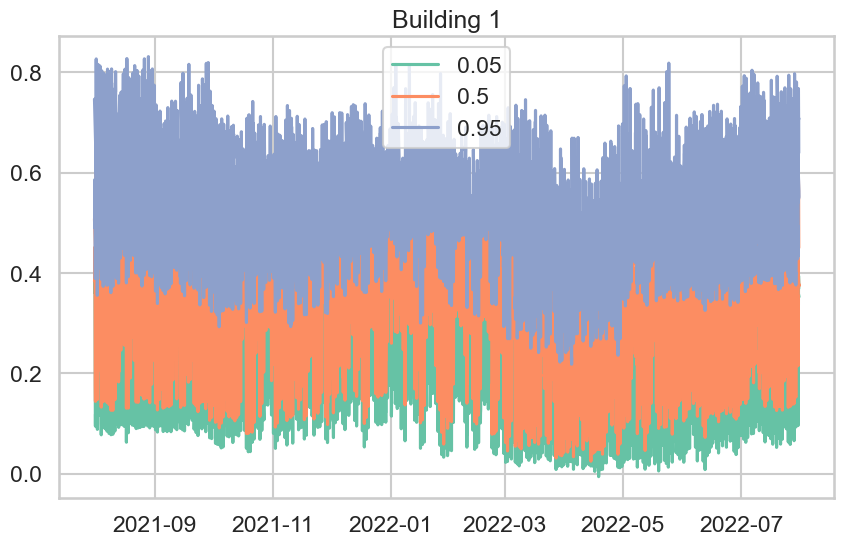

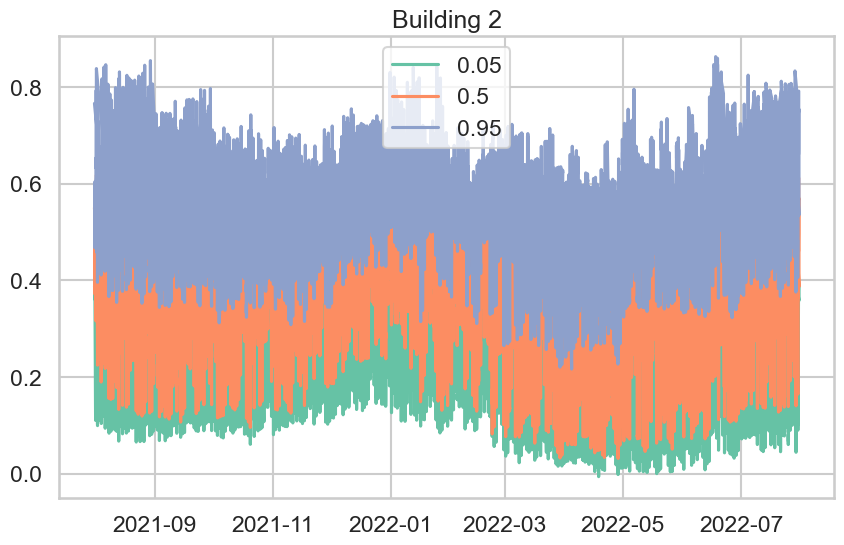

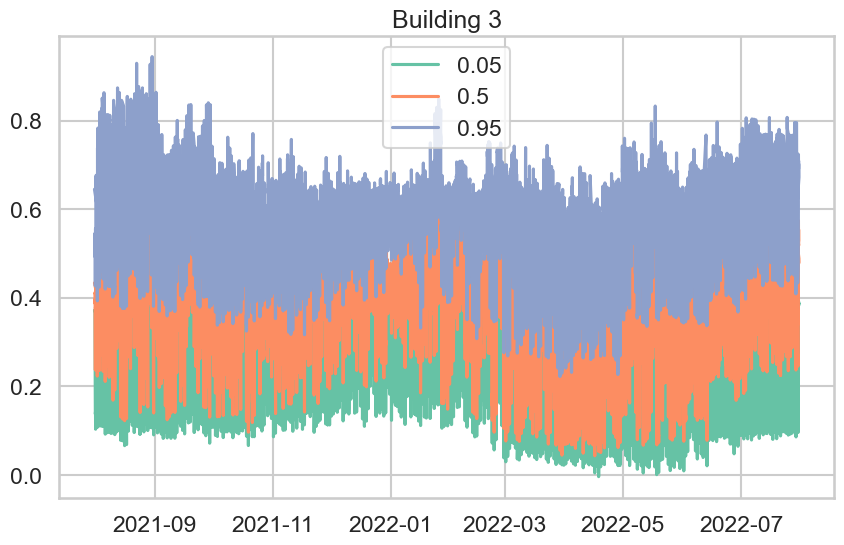

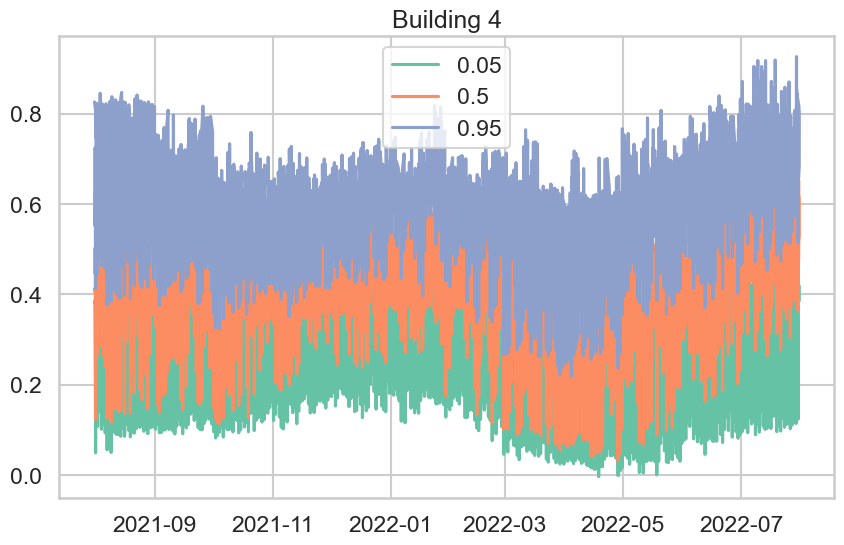

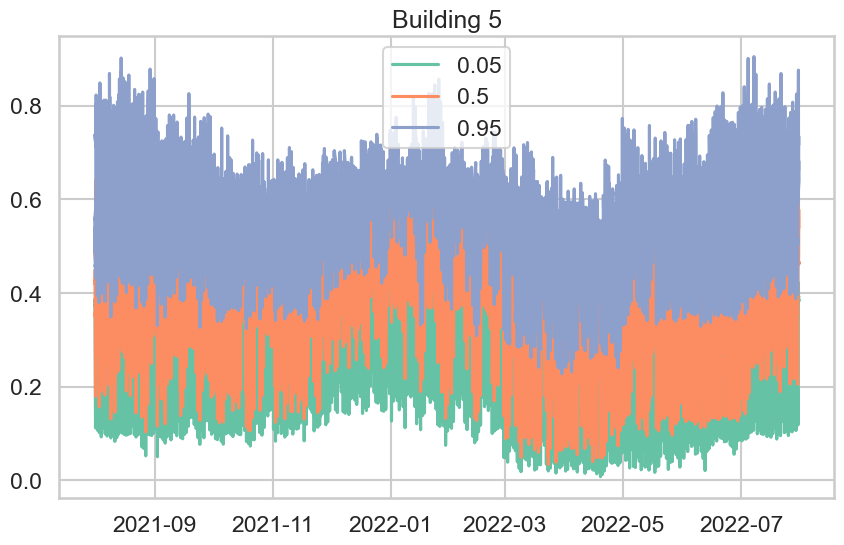

In [84]:
# quantile calibration plot
sns.set_style('whitegrid')
sns.set_context('talk')
sns.set_palette('Set2')
for build in output.number.unique():
    plt.figure(figsize=(10, 6))
    plt.title(f'Building {build}')
    plt.plot(output.loc[output.number==build, 0.05], label='0.05')
    plt.plot(output.loc[output.number==build, 0.5], label='0.5')
    plt.plot(output.loc[output.number==build, 0.95], label='0.95')
    plt.legend()
    plt.show()

In [13]:
output.to_csv('./data/quantile/year_qs.csv', index=True)
output_test.to_csv('./data/quantile/year_qs_test.csv', index=True)

In [5]:
output = pd.read_csv('./data/quantile/year_qs.csv', index_col=0)
output 

,0.001,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,...,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.999,hour
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-08-02 00:00:00,0.303144,0.369353,0.376349,0.380305,0.382202,0.382707,0.386298,0.387832,0.387259,0.388268,...,0.399557,0.402965,0.402966,0.409924,0.421649,0.438896,0.460093,0.489065,0.747136,0
2021-08-02 01:00:00,0.305496,0.369540,0.377217,0.382645,0.382997,0.384135,0.384699,0.385413,0.386054,0.385496,...,0.389481,0.392013,0.397967,0.398482,0.411848,0.424562,0.448965,0.494651,0.743658,1
2021-08-02 02:00:00,0.286406,0.371241,0.378363,0.381176,0.383090,0.384410,0.386936,0.387737,0.388410,0.388770,...,0.395280,0.403726,0.403535,0.408394,0.414624,0.428989,0.438694,0.495129,0.743658,2
2021-08-02 03:00:00,0.286969,0.371241,0.379088,0.383727,0.384219,0.385751,0.387749,0.387367,0.389014,0.388077,...,0.394311,0.395869,0.404769,0.410257,0.416182,0.426240,0.438164,0.490161,0.740722,3
2021-08-02 04:00:00,0.269961,0.351769,0.362449,0.374904,0.375802,0.374120,0.382955,0.387517,0.391618,0.388278,...,0.405398,0.407918,0.412246,0.419744,0.426758,0.437952,0.455525,0.499027,0.741087,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-30 19:00:00,0.307131,0.381668,0.404760,0.413892,0.424813,0.441078,0.439176,0.443101,0.446479,0.463930,...,0.479411,0.492119,0.500108,0.497599,0.522463,0.539418,0.566452,0.635146,0.820193,19
2022-07-30 20:00:00,0.313776,0.384778,0.418112,0.438087,0.446400,0.462508,0.463368,0.468091,0.473173,0.490476,...,0.512539,0.519381,0.525012,0.522898,0.559484,0.571380,0.597751,0.671609,0.817159,20
2022-07-30 21:00:00,0.332102,0.392807,0.432249,0.449053,0.467606,0.480640,0.491217,0.512607,0.520690,0.540575,...,0.585383,0.594138,0.599300,0.618007,0.639146,0.651856,0.683629,0.750670,0.845875,21


In [6]:
data_train

,Month,Hour,cons_target,Solar Generation [W/kW],Outdoor Drybulb Temperature [C],Relative Humidity [%],Diffuse Solar Radiation [W/m2],Direct Solar Radiation [W/m2],day_year,number,...,net,net_target,net+1,net-23,net_target+1,net_target-23,diffuse_solar_radiation+1,direct_solar_radiation+1,relative_humidity+1,drybulb_temp+1
0,8.0,22.0,0.441346,0.000000,19.4,81.0,0.000000,0.000000,23,1,...,3.557083,0.617429,1.411333,2.275800,0.431845,0.506612,0.000000,0.000000,81.0,20.0
1,8.0,23.0,0.170776,0.000000,20.0,81.0,0.000000,0.000000,24,1,...,1.411333,0.431845,0.979417,0.851167,0.394489,0.383397,0.000000,0.000000,87.0,19.4
2,8.0,24.0,0.116313,0.000000,19.4,87.0,0.000000,0.000000,25,1,...,0.979417,0.394489,0.900975,0.834600,0.387705,0.381964,0.000000,0.000000,87.0,19.4
3,8.0,1.0,0.106422,0.000000,19.4,87.0,0.000000,0.000000,26,1,...,0.900975,0.387705,0.922433,0.838167,0.389561,0.382273,0.000000,0.000000,90.0,19.4
4,8.0,2.0,0.109127,0.000000,19.4,90.0,0.000000,0.000000,27,1,...,0.922433,0.389561,0.910483,1.478433,0.388527,0.437649,0.000000,0.000000,90.0,18.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43675,7.0,17.0,0.802751,31.179167,21.1,81.0,5.389072,5.669881,8754,5,...,3.839883,0.862123,2.713900,3.463783,0.720845,0.814933,3.295837,4.875197,84.0,20.6
43676,7.0,18.0,0.552807,4.070833,20.6,84.0,3.295837,4.875197,8755,5,...,2.713900,0.720845,0.935833,0.457167,0.497751,0.437693,0.000000,0.000000,81.0,21.1
43677,7.0,19.0,0.189487,0.000000,21.1,81.0,0.000000,0.000000,8756,5,...,0.935833,0.497751,2.155017,0.714717,0.650722,0.470007,0.000000,0.000000,79.0,21.7
43678,7.0,20.0,0.436347,0.000000,21.7,79.0,0.000000,0.000000,8757,5,...,2.155017,0.650722,2.316400,1.659000,0.670971,0.588487,0.000000,0.000000,76.0,21.3
